In [5]:
# import resources
%matplotlib inline

import torch
from torch import nn
import torch.optim as optim
from torchvision import transforms as T, models

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODELS = {'vgg19': {'model_init': models.vgg19, 'rep_layers':[0, 5, 10, 19, 21, 28]}}

In [11]:
model_name = 'vgg19'
model = MODELS[model_name]['model_init'](pretrained=True).to(device)
layers = MODELS[model_name]['rep_layers']

for param in model.parameters():
    param.requires_grad_(False)

/homes/iws/lpremc/miniconda3/envs/cse490g1/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/homes/iws/lpremc/miniconda3/envs/cse490g1/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def load_image(img_path, size=600, shape=None):
    image = Image.open(img_path).convert('RGB')
    if shape is not None:
        size = shape
    transformation = T.Compose([T.Resize(size), T.ToTensor()])
    image = transformation(image).unsqueeze(0)
    return image

def to_numpy(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image.clip(0, 1)
    return image

def get_features(x):
    features = []
    for name, layer in model.features._modules.items():
        x = layer(x)
        features.append(x)
    return [features[i] for i in layers]

In [12]:
content = load_image('imgs/style1.jpg').to(device)
for x in get_features(content):
    print(x.shape)

torch.Size([1, 64, 600, 809])
torch.Size([1, 128, 300, 404])
torch.Size([1, 256, 150, 202])
torch.Size([1, 512, 75, 101])
torch.Size([1, 512, 75, 101])
torch.Size([1, 512, 37, 50])


In [30]:
mse_loss = nn.MSELoss()

style_weights = [1, 0.8, 0.5, 0.3, 0.1, 0]

def compute_gram(x):
    _, d, w, h = x.shape
    x = x.view(d, h*w)
    return torch.mm(x, x.t())
    
def content_loss(content_features, target_features):
  return mse_loss(target_features[-3], content_features[-3])    

def style_loss(style_features, target_features):
  loss = 0
  for i in range(len(target_features)):
    target_feature = target_features[i]
    _, d, h, w = target_feature.shape
    
    target_gram = compute_gram(target_features[i])
    style_gram = compute_gram(style_features[i])

    loss += style_weights[i] * mse_loss(target_gram, style_gram) / (d * h * w)
  return loss

In [31]:
def style_transfer(content, style, epoch, lr=0.03):
  losses = []
  targets = []
  target = content.clone().requires_grad_(True).to(device)
  optimizer = optim.Adam([target], lr)
  t = tqdm(range(0, epoch))
  grayscale = T.Grayscale(3)
  content_features = get_features(grayscale(content))
  style_features = get_features(style)
  for it in t:
      loss = content_loss(content_features, get_features(grayscale(target))) + style_loss(style_features, get_features(target))
      losses.append(loss.item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  return target, losses 

In [34]:
content = load_image(f'imgs/pic5.jpg').to(device)
style = load_image(f'imgs/style4.jpg').to(device)

In [35]:
target, loss = style_transfer(content, style, 100, lr=0.1)

100%|██████████| 100/100 [00:17<00:00,  5.77it/s]


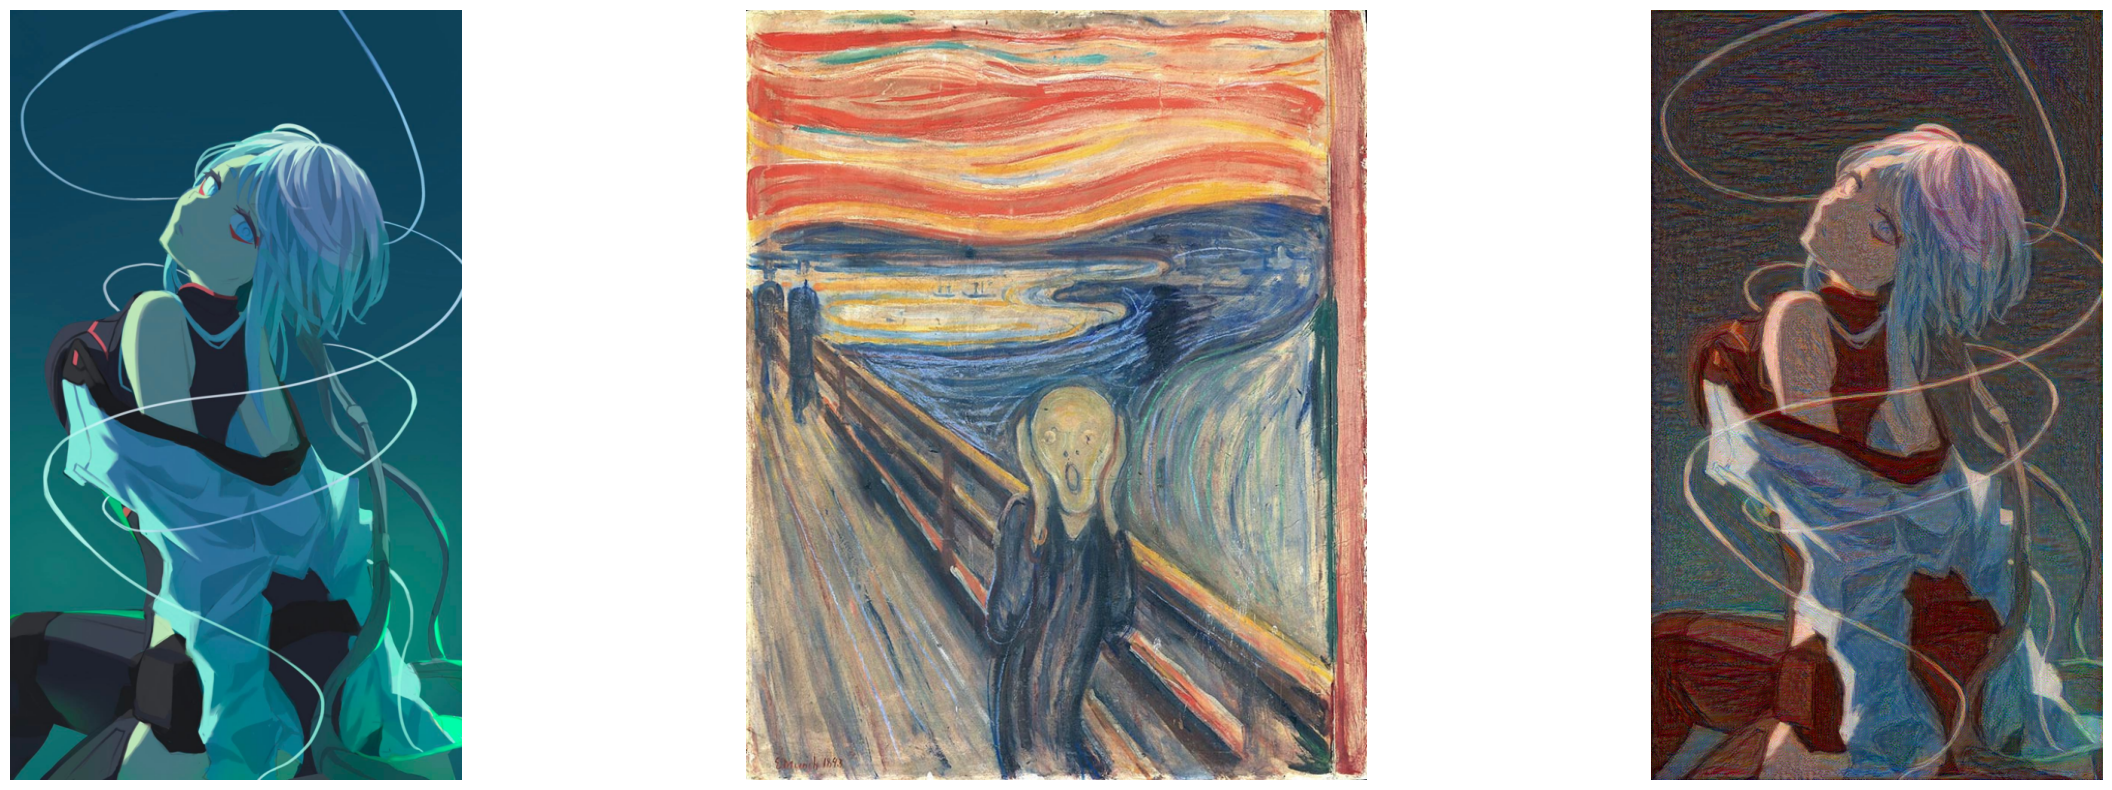

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
ax[0].axis('off')
ax[0].imshow(to_numpy(content))
ax[1].axis('off')
ax[1].imshow(to_numpy(style))
ax[2].axis('off')
ax[2].imshow(to_numpy(target))
fig.show()